# Is BTCUSD associated with the price of different asset classes? If yes – how much?

## A comparison between BTCUSD and Nasdaq, Gold, Silver, Oil, Pigs, Orange Juice and Wheat

### Association is measured by Pearson correlation of daily log returns. Correlation quantifies same-day co-movement and does not imply causality or predictability

L: intro -> talk about data retrieval, yfinance library API, time window of data (2018 - current), data itself (~one third missing data points due to instruments not being traded on the weekend), comparing just weekdays data is fine. log-scale visualization of pure data

J: Correlation matrix over day to day log returns, 90 day rolling avg corr between assets (explain rolling avg to da class), confidence bands ($\pm 1$ SD) $\to$ thicker: more volatile, summary over all average correlations over whole time period



# Imports

In [47]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px
import plotly.graph_objects as go

# Styling

In [48]:
plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams['figure.figsize'] = (10, 6)
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Define assets and download

In [49]:
assets = {
    'BTC-USD': 'Bitcoin',
    '^IXIC': 'Nasdaq',
    'GC=F': 'Gold Futures',
    'SI=F': 'Silver Futures',
    'CL=F': 'Crude Oil',
    'HE=F': 'Lean Hogs',
    'OJ=F': 'Orange Juice'
}

data = yf.download(list(assets.keys()), start="2018-01-01", progress=False)['Close']
data.rename(columns=assets, inplace=True)


# Describe data before imputation

In [50]:
data.describe()

Ticker,Bitcoin,Crude Oil,Gold Futures,Lean Hogs,Orange Juice,Silver Futures,Nasdaq
count,2846.000000,1961.000000,1960.000000,1960.000000,1962.000000,1960.000000,1959.000000
mean,35705.556892,67.932009,1918.768468,80.351276,209.582849,23.053964,12579.915204
std,31122.309438,17.142017,575.754847,17.017413,118.507457,6.572953,4097.675098
min,3236.761719,-37.630001,1176.199951,37.325001,91.250000,11.735000,6192.919922
25%,9348.992676,58.650002,1513.475037,67.406252,119.512501,17.204750,8401.904785
50%,26754.053711,68.589996,1818.149963,80.712498,154.599998,23.052501,12377.179688
75%,53985.554688,77.739998,2005.450043,91.150002,274.050003,26.219250,15225.930176
max,124752.531250,123.699997,4295.700195,122.875000,555.500000,53.375000,23043.380859


# Remove missing data (weekends)

In [51]:
data = data.dropna()

# Describe data after dropna

In [52]:
data.describe()

Ticker,Bitcoin,Crude Oil,Gold Futures,Lean Hogs,Orange Juice,Silver Futures,Nasdaq
count,1958.000000,1958.000000,1958.000000,1958.000000,1958.000000,1958.000000,1958.000000
mean,35711.831735,67.930894,1917.655718,80.354609,209.352452,23.043005,12582.526749
std,31140.431525,17.154503,574.900722,17.025127,118.336149,6.566655,4097.090872
min,3242.484863,-37.630001,1176.199951,37.325001,91.250000,11.735000,6192.919922
25%,9344.527832,58.642500,1512.825012,67.368750,119.500000,17.204250,8416.272461
50%,26755.540039,68.594997,1818.049988,80.712498,154.425003,23.045501,12377.524902
75%,53985.554688,77.762497,2002.499969,91.150002,273.849998,26.215499,15226.320068
max,124752.531250,123.699997,4295.700195,122.875000,555.500000,53.375000,23043.380859


# Visualize daily closing prices of assets (log scale)

In [53]:
df_melted = data.reset_index().melt(id_vars='Date', 
                                   var_name='Asset', 
                                   value_name='Price')

#single line plot with all assets
fig = px.line(df_melted, x='Date', y='Price', 
              color='Asset',
              title='Daily Prices - All Assets',
              log_y=True)

fig.show()


# Create correlation matrix over (daily) log returns 

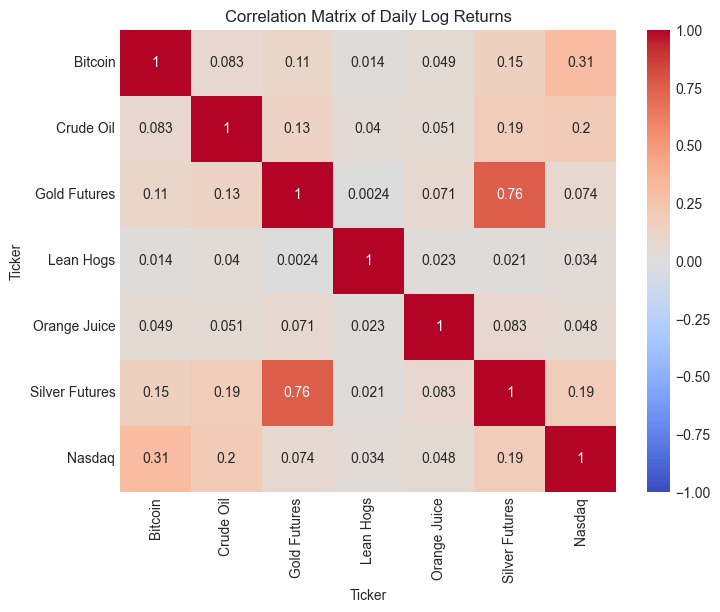

In [54]:
returns = np.log(data / data.shift(1))

corr_matrix = returns.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Daily Log Returns")
plt.show()



# 90 Days rolling average correlation between BTC and (asset)

### (w/ confidence band showing the variability of correlation within the 90-day window)

- Shaded area is $\pm1$ standard deviation of the rolling correlation over the same 90-day window
    - This gives a visual sense of how stable or volatile the correlation is over time

For each asset, we take the series of rolling correlations and compute an SD over the same window

The upper and lower bounds define the confidence interval

How to interpret results: 
- A narrow band indicates a relatively stable correlation over time
- A wide band indicates a volatile correlation $\to$ BTC's relationship with that asset is less predictable over this window

In [55]:
window = 90  # days
rolling_corr = pd.DataFrame()

#rolling correlations
for col in returns.columns:
    if col != 'Bitcoin':
        rolling_corr[col] = returns['Bitcoin'].rolling(window).corr(returns[col])

#rolling standard deviation to create a confidence band
rolling_std = pd.DataFrame()
for col in rolling_corr.columns:
    rolling_std[col] = rolling_corr[col].rolling(window).std()

fig = go.Figure()

for col in rolling_corr.columns:
    #corr line
    fig.add_trace(go.Scatter(
        x=rolling_corr.index,
        y=rolling_corr[col],
        mode='lines',
        name=col
    ))
    
    #conf band
    fig.add_trace(go.Scatter(
        x=rolling_corr.index.tolist() + rolling_corr.index[::-1].tolist(),
        y=(rolling_corr[col] + rolling_std[col]).tolist() + (rolling_corr[col] - rolling_std[col])[::-1].tolist(),
        fill='toself',
        fillcolor='rgba(0,100,80,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=False
    ))

fig.update_layout(
    title=f"{window}-Day Rolling Correlation with Bitcoin (±1 Rolling Std)",
    yaxis=dict(title='Correlation', range=[-1,1]),
    xaxis=dict(title='Date'),
    template='plotly_dark',
    hovermode='x unified'
)

fig.show()


# Summary correlations

In [56]:

summary = corr_matrix.loc['Bitcoin'].drop('Bitcoin').sort_values(ascending=False)
print("Average Correlation with Bitcoin:\n")
print(summary.round(3))


Average Correlation with Bitcoin:

Ticker
Nasdaq            0.312
Silver Futures    0.149
Gold Futures      0.107
Crude Oil         0.083
Orange Juice      0.049
Lean Hogs         0.014
Name: Bitcoin, dtype: float64


In [57]:
fig = px.bar(x=summary.index, y=summary.values,
             labels={'x': 'Asset', 'y': 'Correlation with BTC'},
             title='Asset Correlations with BTC',
             color=summary.values,
             color_continuous_scale='RdBu_r',
             color_continuous_midpoint=0)

fig.update_layout(showlegend=False,
                  coloraxis_colorbar_title='correlation')


fig.update_layout(showlegend=False)
fig.show()


# Conclusion: 

### If Nasdaq is 1 standard deviation up on a day, BTC is on average 0.3 standard deviations up the same day

## Is BTC impacted by the nasdaq?

### This result does not imply causation or predictability. BTC does exhibit a modest positive link to equities (notably Nasdaq) since 2018, but the effect is limited on average and varies over time.